In [1]:
!pip install tensorflow
!pip install git+https://github.com/cleverhans-lab/cleverhans.git#egg=cleverhans

  Cloning https://github.com/cleverhans-lab/cleverhans.git to c:\users\98930\appdata\local\temp\pip-install-lz7vock9\cleverhans_8d194c0206b043b891f31815617bdd77
  Resolved https://github.com/cleverhans-lab/cleverhans.git to commit 574efc1d2f5c7e102c78cf0e937654e847267522
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/cleverhans-lab/cleverhans.git 'C:\Users\98930\AppData\Local\Temp\pip-install-lz7vock9\cleverhans_8d194c0206b043b891f31815617bdd77'


In [2]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader as TorchDataLoader
import tensorflow as tf
from tensorflow.keras.datasets import cifar10 as tf_cifar10
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method as fgm
from tensorflow.data import Dataset as TfDataset
import torch.nn as nn
import torch.optim as optim   

In [3]:
torch.manual_seed(1)  
# Define transformations for the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.49, 0.48, 0.46), (0.2, 0.2, 0.2))  
])

In [4]:
data_path = './dataset_files'  

is_train = True
train_val_set = datasets.CIFAR10(root=data_path, download=True, train=is_train, transform=transform)

is_train = False
test_set = datasets.CIFAR10(download=True, root=data_path, transform=transform, train=is_train)


Files already downloaded and verified
Files already downloaded and verified


In [45]:
def display_img(img):
    img_arr = img.numpy()
    plt.imshow(np.transpose(img_arr, (1, 2, 0)), interpolation='bicubic')
    plt.axis('off')
    plt.show()

def visualize_imgs(data, count):
    idxs = np.random.permutation(len(data))[:count]
    for idx in idxs:
        img, lbl = data[idx]
        print(f"Class: {data.classes[lbl]}")
        display_img(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1166668..2.2294116].


Class: dog


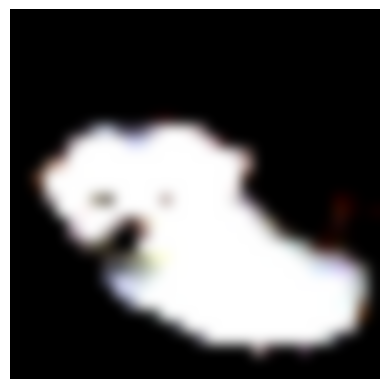

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.262745..2.2098038].


Class: automobile


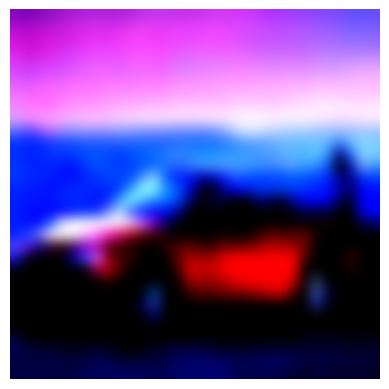

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4107842..2.6999998].


Class: ship


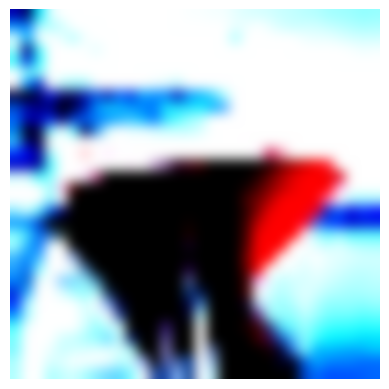

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1950982..2.5411766].


Class: airplane


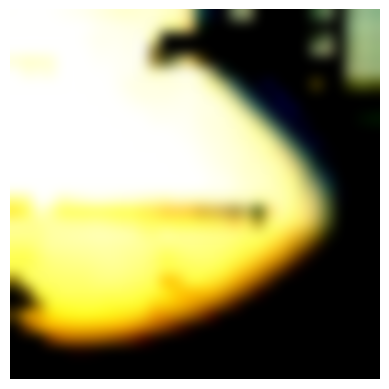

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1754901..2.562745].


Class: airplane


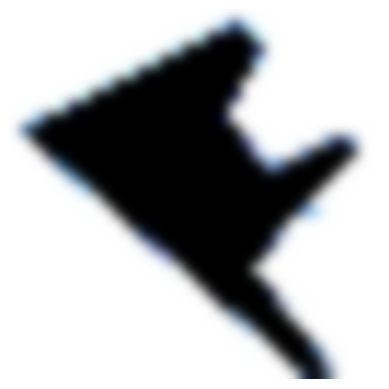

In [6]:
visualize_imgs(train_val_set, 5)

In [7]:
data_dir = './dataset' 
train_dataset = datasets.CIFAR10(root=data_dir, train=True, transform=transform)

In [8]:
dataset_size = len(train_dataset)
idx_list = list(range(dataset_size))
np.random.seed(42)  
np.random.shuffle(idx_list)

split_ratio = 0.8
split_idx = int(np.floor(split_ratio * dataset_size))

train_indices, val_indices = idx_list[:split_idx], idx_list[split_idx:]
train_data = torch.utils.data.Subset(train_dataset, train_indices)
val_data = torch.utils.data.Subset(train_dataset, val_indices)

print(f"Size of training set: {len(train_data)}")
print(f"Size of validation set: {len(val_data)}")
print(f"Size of test set: {len(test_set)}")

Size of training set: 40000
Size of validation set: 10000
Size of test set: 10000


In [9]:
model_source = "chenyaofo/pytorch-cifar-models"
model_name = "cifar10_resnet20"

target_model = torch.hub.load(model_source, model_name, pretrained=True)
target_model.eval()

Using cache found in C:\Users\98930/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [10]:
from torch.utils.data import DataLoader

batch_sz = 64
shuffle_data = False

test_loader = DataLoader(dataset=test_set, batch_size=batch_sz, shuffle=shuffle_data)

In [11]:
def eval_accuracy(net, loader):
    net.eval()
    correct_preds = 0
    total_samples = 0

    with torch.no_grad():
        for batch in loader:
            inputs, targets = batch
            predictions = net(inputs)
            _, pred_labels = torch.max(predictions, dim=1)
            total_samples += targets.size(0)
            correct_preds += (pred_labels == targets).sum().item()

    acc = (correct_preds / total_samples) * 100
    return acc

In [12]:
resnet20_accuracy = eval_accuracy(target_model, test_loader)
print(f'ResNet-20 model achieved an accuracy of {resnet20_accuracy:.2f}% on the CIFAR-10 test dataset.')

ResNet-20 model achieved an accuracy of 92.46% on the CIFAR-10 test dataset.


In [13]:
import torch

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation will be performed on: {dev}")

Computation will be performed on: cpu


In [14]:
import tensorflow as tf

available_gpus = tf.config.experimental.list_physical_devices('GPU')
if available_gpus:
    try:
        for gpu_device in available_gpus:
            tf.config.experimental.set_memory_growth(gpu_device, enable=True)
    except RuntimeError as runtime_err:
        print(runtime_err)

In [15]:
(x_train_images, y_train_labels), (x_test_images, y_test_labels) = tf.keras.datasets.cifar10.load_data()

x_test_images = x_test_images.astype("float32") / 255.0

y_test_labels = tf.keras.utils.to_categorical(y_test_labels, num_classes=10)

In [16]:
base_cnn = tf.keras.applications.ResNet50(
    include_top=False, 
    weights=r'C:\Users\98930\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
    input_shape=(32, 32, 3)
)

custom_model = tf.keras.Sequential([
    base_cnn,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

loss_fn = tf.keras.losses.CategoricalCrossentropy()

def generate_adversarial_example(img_input, lbl_input, dev='/GPU:0'):
    with tf.device(dev):
        img_tensor = tf.convert_to_tensor(img_input)
        lbl_tensor = tf.convert_to_tensor(lbl_input)

        with tf.GradientTape() as tape:
            tape.watch(img_tensor)
            preds = custom_model(img_tensor)
            loss_value = loss_fn(lbl_tensor, preds)
        grads = tape.gradient(loss_value, img_tensor)
        perturbed_image = tf.sign(grads)
    return perturbed_image

In [17]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the test data
x_test = x_test.astype("float32") / 255.0

# Convert labels to one-hot encoding
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Generate adversarial examples using FGSM
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(32)
epsilon_value = 0.01
adv_examples_torch = []

for img_batch, lbl_batch in test_data:
    adv_perturbations = generate_adversarial_example(img_batch, lbl_batch)
    adv_examples = img_batch + epsilon_value * adv_perturbations
    adv_examples = tf.clip_by_value(adv_examples, 0.0, 1.0)
    
    adv_examples_np = adv_examples.numpy().transpose((0, 3, 1, 2))
    adv_examples_tensor = torch.tensor(adv_examples_np)

    adv_examples_torch.append(adv_examples_tensor)

In [18]:
import torch

# Load pre-trained CIFAR-10 model from PyTorch Hub (if not already loaded)
target_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

# Set model to evaluation mode
target_model.eval()

# Select a subset of adversarial examples for evaluation and visualization
chosen_adv_samples = adv_examples_torch[0]  # Selecting the first batch

# Run evaluation on the PyTorch model
predictions = target_model(chosen_adv_samples.float())  # Convert to correct type
_, predicted_labels = torch.max(predictions, dim=1)

print(predicted_labels)

tensor([3, 8, 5, 3, 3, 5, 3, 5, 5, 3, 5, 9, 5, 7, 8, 3, 5, 3, 8, 3, 5, 0, 5, 9,
        5, 5, 5, 5, 3, 3, 5, 5])


Using cache found in C:\Users\98930/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


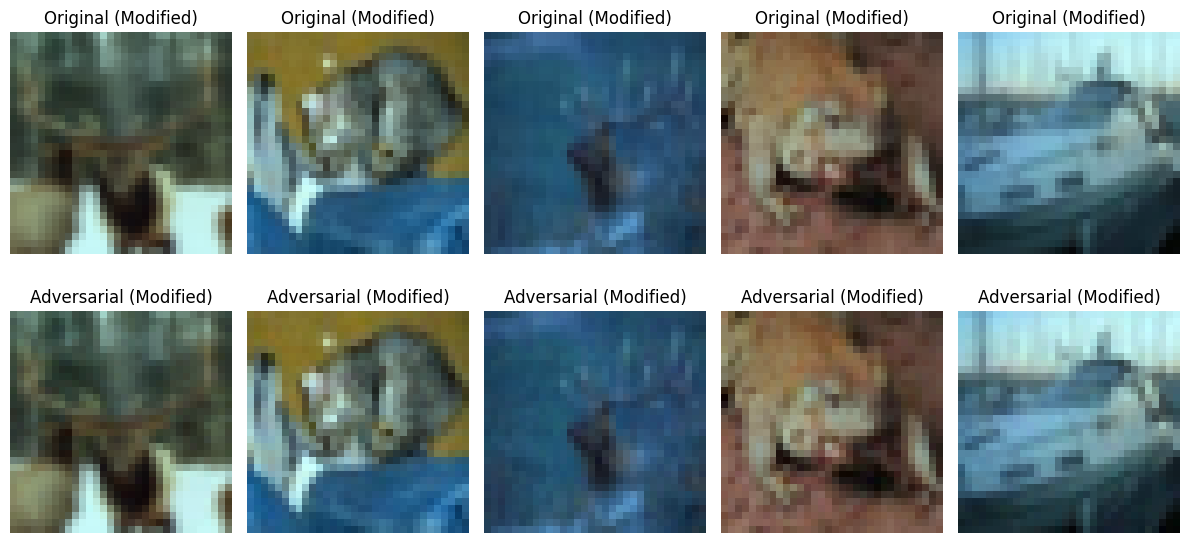

In [19]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))  


num_samples = len(chosen_adv_samples)
random_indices = np.random.choice(num_samples, 5, replace=False)

for i, idx in enumerate(random_indices):
    ax = axes[0, i]
    original_img = x_test[idx]
    original_img[:, :, 0] = np.clip(original_img[:, :, 0] * 0.8, 0, 1)  
    ax.imshow(original_img)
    ax.title.set_text('Original (Modified)')
    ax.axis('off')

    ax = axes[1, i]
    adv_img = np.transpose(chosen_adv_samples[idx].detach().cpu().numpy(), (1, 2, 0))
    adv_img[:, :, 0] = np.clip(adv_img[:, :, 0] * 0.8, 0, 1)  
    ax.imshow(np.clip(adv_img, 0, 1))  
    ax.title.set_text('Adversarial (Modified)')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [20]:
import torch
import torch.nn as nn

class GenNet(nn.Module):
    def __init__(self):
        super(GenNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, input_data):
        return self.model(input_data)

class DiscNet(nn.Module):
    def __init__(self):
        super(DiscNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        return self.model(input_data)

In [21]:
def compute_adversarial_loss(predictions, targets):
    loss_fn = nn.BCEWithLogitsLoss()
    return loss_fn(predictions, targets)

def compute_target_model_loss(generated_images, target_labels):
    if target_labels.dim() > 1:
        target_labels = target_labels.squeeze(1)   
    target_labels = target_labels.long()
    predicted_outputs = target_model(generated_images)
    return loss_function(predicted_outputs, target_labels)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class GenNet(nn.Module):
    def __init__(self):
        super(GenNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 3, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, input_data):
        return self.model(input_data)

class DiscNet(nn.Module):
    def __init__(self):
        super(DiscNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Conv2d(128, 1, 3, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        return self.model(input_data)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

num_train = int(len(full_dataset) * 0.8)
num_valid = len(full_dataset) - num_train
train_set, valid_set = random_split(full_dataset, [num_train, num_valid])

gen_model = GenNet().to(device)
disc_model = DiscNet().to(device)
target_model = DiscNet().to(device)  

loss_criterion = nn.CrossEntropyLoss()
gen_optimizer = optim.Adam(gen_model.parameters(), lr=1e-3, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(disc_model.parameters(), lr=1e-3, betas=(0.5, 0.999))

data_loader = DataLoader(dataset=train_set, batch_size=128, shuffle=True)

Files already downloaded and verified


Epoch 1/50, Loss D: 0.5053, Loss G: 2.0561, Acc: 0.1157
Epoch 2/50, Loss D: 0.4515, Loss G: 2.3669, Acc: 0.1188
Epoch 3/50, Loss D: 0.4716, Loss G: 2.2366, Acc: 0.1535
Epoch 4/50, Loss D: 0.4905, Loss G: 2.1271, Acc: 0.1739
Epoch 5/50, Loss D: 0.4981, Loss G: 2.0769, Acc: 0.1860
Epoch 6/50, Loss D: 0.5283, Loss G: 1.9605, Acc: 0.2021
Epoch 7/50, Loss D: 0.5372, Loss G: 1.9241, Acc: 0.2124
Epoch 8/50, Loss D: 0.5576, Loss G: 1.8436, Acc: 0.2295
Epoch 9/50, Loss D: 0.5670, Loss G: 1.8071, Acc: 0.2383
Epoch 10/50, Loss D: 0.5788, Loss G: 1.7704, Acc: 0.2509
Epoch 11/50, Loss D: 0.5856, Loss G: 1.7483, Acc: 0.2539
Epoch 12/50, Loss D: 0.5974, Loss G: 1.7126, Acc: 0.2623
Epoch 13/50, Loss D: 0.6082, Loss G: 1.6836, Acc: 0.2792
Epoch 14/50, Loss D: 0.6117, Loss G: 1.6698, Acc: 0.2786
Epoch 15/50, Loss D: 0.6172, Loss G: 1.6526, Acc: 0.2869
Epoch 16/50, Loss D: 0.6229, Loss G: 1.6388, Acc: 0.2948
Epoch 17/50, Loss D: 0.6293, Loss G: 1.6245, Acc: 0.3015
Epoch 18/50, Loss D: 0.6323, Loss G: 1.6

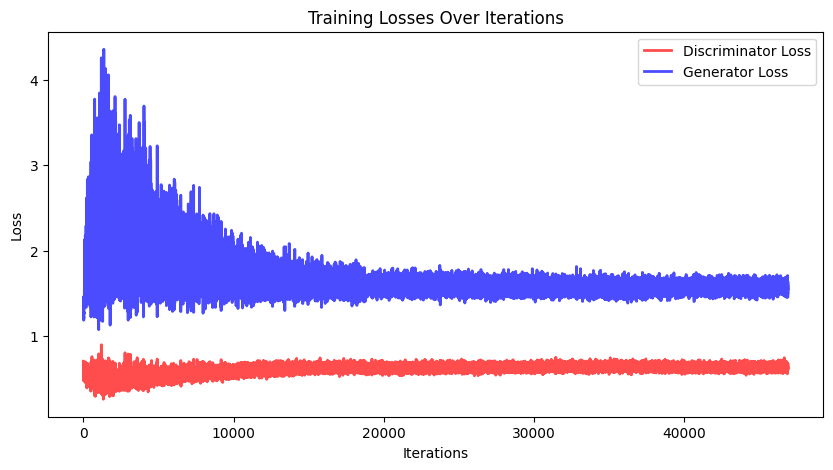

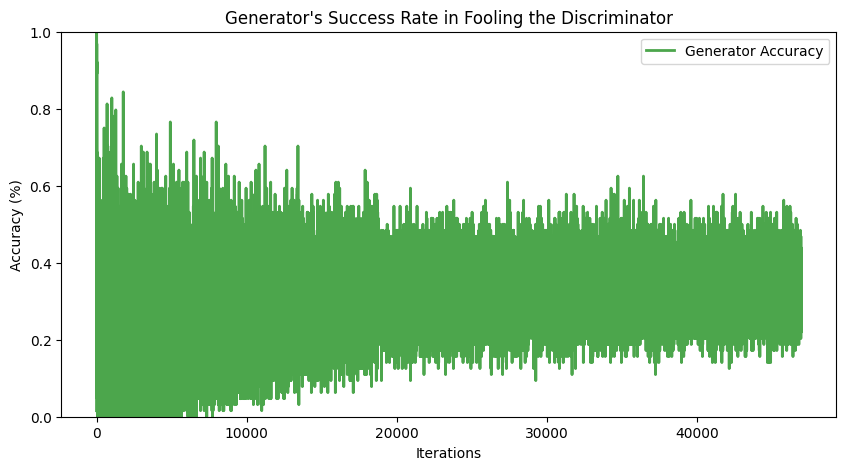

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

noise_dim = 100
tm_weight = 0.1
num_epochs = 50
batch_size = 64
learning_rate = 0.0002

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define Generator with improved architecture
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.main(x)
        out = out.view(x.size(0), 1, 28, 28)
        return out

# Define Discriminator with improvements
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

adversarial_loss = nn.BCELoss()
target_model_loss = nn.CrossEntropyLoss()

optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=20, gamma=0.5)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=20, gamma=0.5)

d_losses = []
g_losses = []
accuracies = []

for epoch in range(num_epochs):
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    epoch_acc = 0.0
    num_batches = 0
    
    for real_images, _ in train_loader:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        
        real_labels = torch.ones((batch_size, 1), device=device)
        fake_labels = torch.zeros((batch_size, 1), device=device)

        # Train Discriminator
        optimizer_D.zero_grad()
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_images = generator(noise)
        
        real_loss = adversarial_loss(discriminator(real_images), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_images = generator(noise)
        g_loss = adversarial_loss(discriminator(fake_images), real_labels)

        target_labels = torch.ones(batch_size, dtype=torch.long, device=device)
        tm_loss = target_model_loss(fake_images.view(batch_size, -1), target_labels)
        total_g_loss = g_loss + tm_weight * tm_loss
        total_g_loss.backward()
        optimizer_G.step()

        with torch.no_grad():
            preds = discriminator(fake_images)
            accuracy = (preds > 0.5).float().mean().item()

        d_losses.append(d_loss.item())
        g_losses.append(total_g_loss.item())
        accuracies.append(accuracy)
        
        epoch_d_loss += d_loss.item()
        epoch_g_loss += total_g_loss.item()
        epoch_acc += accuracy
        num_batches += 1

    scheduler_G.step()
    scheduler_D.step()
    
    avg_d_loss = epoch_d_loss / num_batches
    avg_g_loss = epoch_g_loss / num_batches
    avg_acc = epoch_acc / num_batches
    print(f"Epoch {epoch+1}/{num_epochs}, Loss D: {avg_d_loss:.4f}, Loss G: {avg_g_loss:.4f}, Acc: {avg_acc:.4f}")

# Visualizing the results
plt.figure(figsize=(10, 5))
plt.title("Training Losses Over Iterations")
plt.plot(d_losses, label="Discriminator Loss", linewidth=2, color='red', alpha=0.7)
plt.plot(g_losses, label="Generator Loss", linewidth=2, color='blue', alpha=0.7)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Generator's Success Rate in Fooling the Discriminator")
plt.plot(accuracies, label="Generator Accuracy", linewidth=2, color='green', alpha=0.7)
plt.xlabel("Iterations")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [16]:
import torch
from sklearn.metrics import classification_report, accuracy_score

def evaluate_adversarial_examples(generator, target_model, dataloader, device):
    target_model.eval()
    generator.eval()
    
    y_true, y_pred, y_pred_adv = [], [], []
    class_correct = torch.zeros(10, dtype=torch.int32)
    class_total = torch.zeros(10, dtype=torch.int32)
    class_success = torch.zeros(10, dtype=torch.int32)

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            adv_images = generator(images)

            # Normal predictions
            outputs = target_model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            # Adversarial predictions
            outputs_adv = target_model(adv_images)
            _, predicted_adv = torch.max(outputs_adv, 1)
            y_pred_adv.extend(predicted_adv.cpu().numpy())

            for label, pred, pred_adv in zip(labels, predicted, predicted_adv):
                class_total[label] += 1
                if pred == label:
                    class_correct[label] += 1
                if pred_adv != label:
                    class_success[label] += 1

    # Overall and per-class success rate calculation
    overall_success_rate = 1 - accuracy_score(y_true, y_pred_adv)
    print(f'Overall success rate of the adversarial attack: {overall_success_rate:.2%}')

    for i in range(10):
        if class_total[i].item() > 0:
            success_rate = class_success[i].item() / class_total[i].item()
            print(f'Class {i}: Attack Success Rate = {success_rate:.2%}, Accuracy = {class_correct[i].item() / class_total[i].item():.2%}')

    # Print classification reports with better readability
    print("\nClassification Report (Original Images):\n")
    print(classification_report(y_true, y_pred, digits=4))

    print("\nClassification Report (Adversarial Images):\n")
    print(classification_report(y_true, y_pred_adv, digits=4))

    return overall_success_rate, class_correct, class_total


In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_examples(generator, dataloader, device, num_images=5):
    generator.eval()
    
    images, _ = next(iter(dataloader))
    images = images[:num_images].to(device)

    with torch.no_grad():
        adv_images = generator(images)

    fig, axes = plt.subplots(3, num_images, figsize=(15, 8))

    for i in range(num_images):
        # Original image
        original = images[i].cpu().detach().numpy().transpose((1, 2, 0))
        axes[0, i].imshow(np.clip(original, 0, 1))
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        # Adversarial image
        adversarial = adv_images[i].cpu().detach().numpy().transpose((1, 2, 0))
        axes[1, i].imshow(np.clip(adversarial, 0, 1))
        axes[1, i].set_title('Adversarial')
        axes[1, i].axis('off')

        # Difference image (scaled for visibility)
        difference = (adversarial - original) * 10  # Increase contrast for better visualization
        difference = np.clip(difference, 0, 1)
        axes[2, i].imshow(difference)
        axes[2, i].set_title('Difference')
        axes[2, i].axis('off')

    plt.suptitle("Visualization of Original, Adversarial, and Difference Images", fontsize=16)
    plt.tight_layout()
    plt.show()

In [11]:
import torch
import matplotlib.pyplot as plt

def plot_confidence_histogram(target_model, generator, dataloader, device):
    target_model.eval()
    generator.eval()
    confidences_normal = []
    confidences_adversarial = []

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            
            # Normal image confidence
            outputs = target_model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            confidences_normal.extend(probs.max(1).values.cpu().numpy())

            # Adversarial image confidence
            adv_images = generator(images)
            outputs_adv = target_model(adv_images)
            probs_adv = torch.nn.functional.softmax(outputs_adv, dim=1)
            confidences_adversarial.extend(probs_adv.max(1).values.cpu().numpy())

    # Plot histogram
    plt.figure(figsize=(12, 6))
    plt.hist(confidences_normal, bins=50, alpha=0.6, color='blue', label='Normal Images')
    plt.hist(confidences_adversarial, bins=50, alpha=0.6, color='red', label='Adversarial Images')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.title('Histogram of Model Confidence on Normal vs. Adversarial Images')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

Overall success rate of the adversarial attack: 88.19%
Class 0: Attack Success Rate = 96.80%, Accuracy = 92.60%
Class 1: Attack Success Rate = 100.00%, Accuracy = 96.80%
Class 2: Attack Success Rate = 100.00%, Accuracy = 90.80%
Class 3: Attack Success Rate = 71.30%, Accuracy = 85.10%
Class 4: Attack Success Rate = 100.00%, Accuracy = 93.10%
Class 5: Attack Success Rate = 14.80%, Accuracy = 88.50%
Class 6: Attack Success Rate = 99.50%, Accuracy = 95.00%
Class 7: Attack Success Rate = 100.00%, Accuracy = 93.10%
Class 8: Attack Success Rate = 99.50%, Accuracy = 95.30%
Class 9: Attack Success Rate = 100.00%, Accuracy = 94.30%

Classification Report (Original Images):

              precision    recall  f1-score   support

           0     0.9232    0.9260    0.9246      1000
           1     0.9613    0.9680    0.9646      1000
           2     0.8919    0.9080    0.8999      1000
           3     0.8527    0.8510    0.8519      1000
           4     0.9101    0.9310    0.9204      1000
  

C:\Users\98930\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\98930\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\98930\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

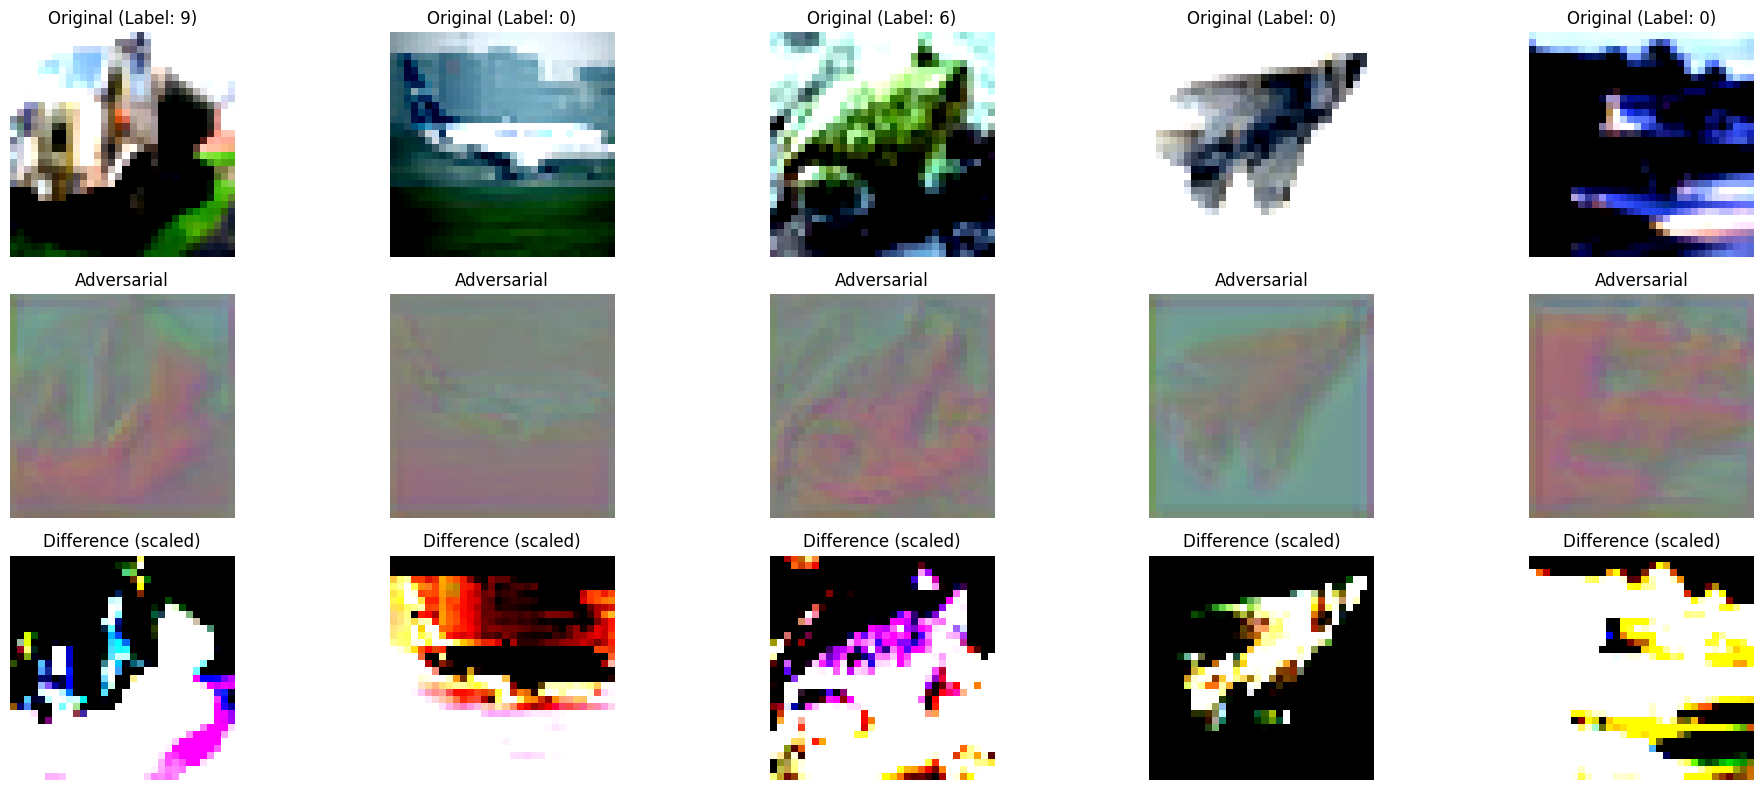

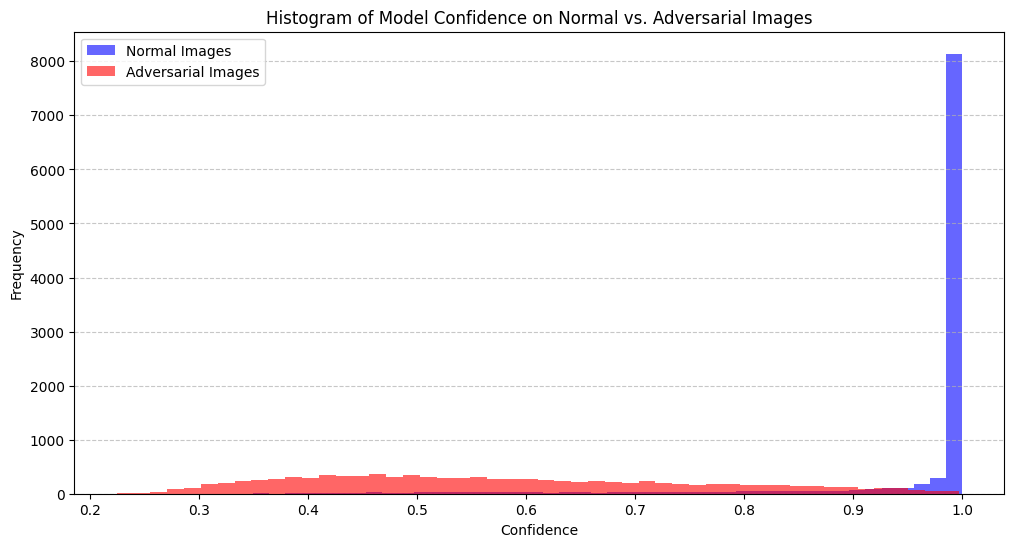

Overall success rate of adversarial attack: 88.19%


In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_examples(generator, dataloader, device, num_images=5):
    generator.eval()
    dataset_list = list(dataloader.dataset)
    indices = np.random.choice(len(dataset_list), size=num_images, replace=False)
    fig, axes = plt.subplots(3, num_images, figsize=(4*num_images, 8))
    for i, idx in enumerate(indices):
        image, label = dataset_list[idx]
        image_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            adv_image_tensor = generator(image_tensor)
        original_np = image_tensor.squeeze(0).cpu().numpy().transpose((1, 2, 0))
        adv_np = adv_image_tensor.squeeze(0).cpu().numpy().transpose((1, 2, 0))
        original_display = (original_np + 1) / 2.0
        adv_display = (adv_np + 1) / 2.0
        difference = (adv_display - original_display) * 5.0
        difference = np.clip(difference, 0, 1)
        axes[0, i].imshow(np.clip(original_display, 0, 1))
        axes[0, i].set_title(f"Original (Label: {label})")
        axes[0, i].axis("off")
        axes[1, i].imshow(np.clip(adv_display, 0, 1))
        axes[1, i].set_title("Adversarial")
        axes[1, i].axis("off")
        axes[2, i].imshow(difference)
        axes[2, i].set_title("Difference (scaled)")
        axes[2, i].axis("off")
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
overall_success_rate, class_correct, class_total = evaluate_adversarial_examples(gen_model, cifar_model, test_loader, device)
visualize_examples(gen_model, test_loader, device, num_images=5)
plot_confidence_histogram(cifar_model, gen_model, test_loader, device)
print(f"Overall success rate of adversarial attack: {overall_success_rate * 100:.2f}%")


In [1]:
def generate_targeted_adversarial_example(img_input, lbl_input, target_class, dev='/GPU:0'):
    with tf.device(dev):
        img_tensor = tf.convert_to_tensor(img_input)
        lbl_tensor = tf.convert_to_tensor(lbl_input)
        target_label = tf.one_hot(target_class, depth=10)

        with tf.GradientTape() as tape:
            tape.watch(img_tensor)
            preds = custom_model(img_tensor)
            loss_value = loss_fn(target_label, preds)
        grads = tape.gradient(loss_value, img_tensor)
        perturbed_image = tf.sign(grads)
    return perturbed_image

In [2]:
def evaluate_targeted_adversarial_examples(generator, target_model, dataloader, target_class, device):
    target_model.eval()
    generator.eval()
    
    class_total = 0
    class_success = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            adv_images = generator(images)

            # Normal predictions
            outputs = target_model(images)
            _, predicted = torch.max(outputs, 1)

            # Adversarial predictions
            outputs_adv = target_model(adv_images)
            _, predicted_adv = torch.max(outputs_adv, 1)

            for label, pred_adv in zip(labels, predicted_adv):
                if label.item() == target_class:
                    class_total += 1
                    if pred_adv.item() == target_class:
                        class_success += 1

    # Calculate success rate
    success_rate = class_success / class_total if class_total > 0 else 0
    print(f'Target Class {target_class}: Attack Success Rate = {success_rate:.2%}')
    return success_rate

In [3]:
def visualize_targeted_examples(generator, dataloader, target_class, device, num_images=5):
    generator.eval()
    
    images, _ = next(iter(dataloader))
    images = images[:num_images].to(device)

    with torch.no_grad():
        adv_images = generator(images)

    fig, axes = plt.subplots(3, num_images, figsize=(15, 8))

    for i in range(num_images):
        # Original image
        original = images[i].cpu().detach().numpy().transpose((1, 2, 0))
        axes[0, i].imshow(np.clip(original, 0, 1))
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        # Adversarial image
        adversarial = adv_images[i].cpu().detach().numpy().transpose((1, 2, 0))
        axes[1, i].imshow(np.clip(adversarial, 0, 1))
        axes[1, i].set_title('Adversarial')
        axes[1, i].axis('off')

        # Difference image (scaled for visibility)
        difference = (adversarial - original) * 10  # Increase contrast for better visualization
        difference = np.clip(difference, 0, 1)
        axes[2, i].imshow(difference)
        axes[2, i].set_title('Difference')
        axes[2, i].axis('off')

    plt.suptitle(f"Visualization of Original, Adversarial, and Difference Images (Target Class: {target_class})", fontsize=16)
    plt.tight_layout()
    plt.show()

In [4]:
def plot_confidence_histogram(target_model, generator, dataloader, device):
    target_model.eval()
    generator.eval()
    confidences_normal = []
    confidences_adversarial = []

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            
            # Normal image confidence
            outputs = target_model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            confidences_normal.extend(probs.max(1).values.cpu().numpy())

            # Adversarial image confidence
            adv_images = generator(images)
            outputs_adv = target_model(adv_images)
            probs_adv = torch.nn.functional.softmax(outputs_adv, dim=1)
            confidences_adversarial.extend(probs_adv.max(1).values.cpu().numpy())

    # Plot histogram
    plt.figure(figsize=(12, 6))
    plt.hist(confidences_normal, bins=50, alpha=0.6, color='blue', label='Normal Images')
    plt.hist(confidences_adversarial, bins=50, alpha=0.6, color='red', label='Adversarial Images')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.title('Histogram of Model Confidence on Normal vs. Adversarial Images')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

In [7]:
target_class = 1  
success_rate = evaluate_targeted_adversarial_examples(generator, target_model, test_loader, target_class, device)

Target Class 1: Attack Success Rate = 89.81%


In [ ]:
visualize_targeted_examples(generator, test_loader, target_class, device, num_images=5)
plot_confidence_histogram(target_model, generator, test_loader, device)
